In [1]:
# Imports
import copy
import pandas as pd
from sklearn.decomposition import PCA
import sqlite3
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

In [2]:
# Connect to database
conn = sqlite3.connect('../data.db')
c = conn.cursor()

## Part 1: Grouping Parks through KMeans Clustering

In [4]:
# Query to return counts of each category of species by park, keeping location information.

query = """
    SELECT Park_Name, Park_Code, State, Latitude, Longitude,
        SUM(CASE WHEN Category = 'Mammal' THEN 1 ELSE 0 END) AS Mammal_Count,
        SUM(CASE WHEN Category = 'Bird' THEN 1 ELSE 0 END) AS Bird_Count,
        SUM(CASE WHEN Category = 'Reptile' THEN 1 ELSE 0 END) AS Reptile_Count,
        SUM(CASE WHEN Category = 'Amphibian' THEN 1 ELSE 0 END) AS Amphibian_Count,
        SUM(CASE WHEN Category = 'Fish' THEN 1 ELSE 0 END) AS Fish_Count,
        SUM(CASE WHEN Category = 'Vascular Plant' THEN 1 ELSE 0 END) AS Vascular_Plant_Count,
        SUM(CASE WHEN Category = 'Non-vascular Plant' THEN 1 ELSE 0 END) AS Non_vascular_Plant_Count,
        SUM(CASE WHEN Category = 'Spider/Scorpion' THEN 1 ELSE 0 END) AS Spider_Scorpion_Count,
        SUM(CASE WHEN Category = 'Insect' THEN 1 ELSE 0 END) AS Insect_Count,
        SUM(CASE WHEN Category = 'Fungi' THEN 1 ELSE 0 END) AS Fungi_Count,
        SUM(CASE WHEN Category = 'Protozoa' THEN 1 ELSE 0 END) AS Protozoa_Count,
        SUM(CASE WHEN Category = 'Slug/Snail' THEN 1 ELSE 0 END) AS Slug_Snail_Count,
        SUM(CASE WHEN Category = 'Other Non-vertebrates' THEN 1 ELSE 0 END) AS Other_Non_vertebrates_Count,
        SUM(CASE WHEN Category = 'Crab/Lobster/Shrimp' THEN 1 ELSE 0 END) AS Crab_Lobster_Shrimp_Count,
        SUM(CASE WHEN Category = 'Bacteria' THEN 1 ELSE 0 END) AS Bacteria_Count,
        SUM(CASE WHEN Category = 'Chromista' THEN 1 ELSE 0 END) AS Chromista_Count
    FROM final
    GROUP BY Park_Code;
"""
raw_data = pd.read_sql_query(query, conn)

# Extract labels of parks - Note that we also keep Latitude and Longitude to later Verify KMeans/KNN results.
park_labels = pd.DataFrame(raw_data[['Park_Name', 'Park_Code','State', 'Latitude', 'Longitude']])
unlabeled = raw_data.drop(columns=['Park_Name', 'Park_Code','State'])
original_kmean_frame = unlabeled.copy()

# Standardize the data
unlabeled = unlabeled.div(unlabeled.sum(axis=1), axis=0)

# Map data to a lower dimension 2d space using Principal Component Analysis
pca_model = PCA(n_components=2)
dim_reduced = pca_model.fit_transform(unlabeled)

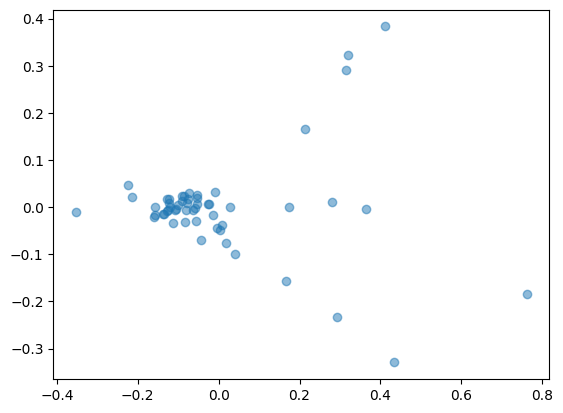

In [5]:
# Plots the data above, for our own sake
fig = plt.figure()
ax = fig.add_subplot()

x = dim_reduced[:, 0]
y = dim_reduced[:, 1]

ax.scatter(x, y, alpha=0.5)
plt.show()

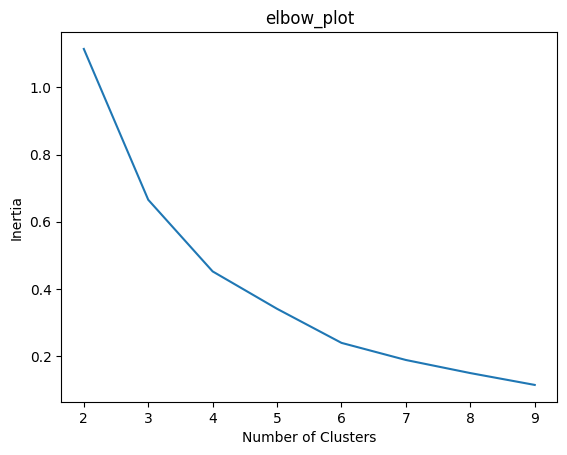

In [6]:
# KMeans cluster

def elbow_plot(cluster, errors):
    plt.clf()
    plt.plot(cluster, errors)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('elbow_plot')

# For each k value 2-10, calculate the inertia.
# Then plot an elbow plot.
k = range(2,10)
inertia = np.array([])
for i in range(2,10):
    kmeans = KMeans(i).fit(dim_reduced)
    inertia = np.append(inertia, kmeans.inertia_)
elbow_plot(k, inertia)

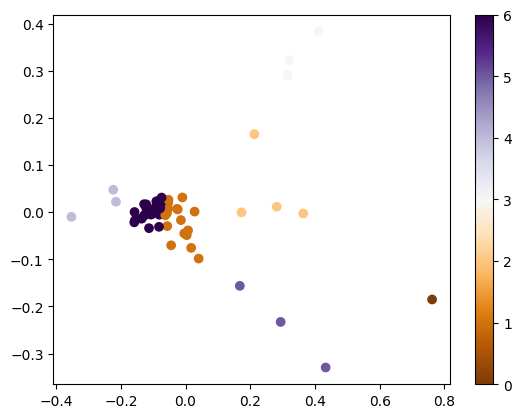

In [7]:
# Our optimal k value from the elbow plot is 7.
num_classes = 7
clustering = KMeans(num_classes).fit_predict(dim_reduced)

# Plot data clusters in our 2D space.
x = dim_reduced[:,0]
y = dim_reduced[:,1]
scat = plt.scatter(x, y, c=clustering, cmap='PuOr')
cb = plt.colorbar(scat, spacing='proportional',ticks=(np.linspace(0,num_classes,num_classes+1)))
plt.show()


As seen in our poster we then go on to plot this on a map of the US and make further observations there.

## Part 2: Predicting Biodiversity Distributions using Deep Learning

### 1. Preprocess


In [8]:
# Count all rows, as each row has a unique scientific animal. Visitors will be validation
biodiversity_query ='''Select park_code,acres,Latitude,longitude,count(*) as Biodiversity,Visitors
from final
group by park_code;'''

def get_percent(col_name,frame):
    return frame[col_name] / frame['total_species']

original_kmean_frame.loc[:,'total_species'] = original_kmean_frame.sum(axis=1)
biodiversity_data = pd.read_sql(biodiversity_query,conn)
original_kmean_frame.head()

,Latitude,Longitude,Mammal_Count,Bird_Count,Reptile_Count,Amphibian_Count,Fish_Count,Vascular_Plant_Count,Non_vascular_Plant_Count,Spider_Scorpion_Count,Insect_Count,Fungi_Count,Protozoa_Count,Slug_Snail_Count,Other_Non_vertebrates_Count,Crab_Lobster_Shrimp_Count,Bacteria_Count,Chromista_Count,total_species
0,44.35,-68.21,38,214,7,11,33,860,0,0,0,0,0,0,0,0,0,0,1139.14
1,38.68,-109.57,43,177,14,5,10,471,0,0,0,0,0,0,0,0,0,0,649.11
2,43.75,-102.50,36,206,6,5,15,444,0,0,21,0,0,0,0,0,0,0,674.25
3,29.25,-103.25,78,407,55,11,41,1323,0,0,0,0,0,0,0,0,0,0,1841.00
4,25.65,-80.08,24,229,31,7,547,444,0,0,10,0,0,0,34,0,0,0,1271.57


In [9]:
X = original_kmean_frame[['Latitude','Longitude']].to_numpy()
Y = original_kmean_frame.drop(columns=['Latitude','Longitude'])
Y = Y.astype(float)
Y = Y.divide(Y['total_species'],axis='rows')
Y = Y.drop(columns=['total_species'])
Y = Y.to_numpy()

### 2. Train Model

In [ ]:
# Import deep learning libraries
import tensorflow as tf
from collections import defaultdict
from sklearn.model_selection import KFold

# Run our model on several kfolds.
mean_absolute_error = tf.keras.losses.MeanAbsoluteError()
mean_squared_error = tf.keras.losses.MeanSquaredError()
training_losses = defaultdict(lambda:0)
testing_losses = defaultdict(lambda:0)
histories = []
kfold = KFold()
for train,test in kfold.split(X,Y):
    # Simple sequential model of dense and dropout layers.
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(20,activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(8,activation='softmax'),
        tf.keras.layers.Dense(16)
        ])

    # Save histories for plotting.
    model.compile(optimizer=tf.keras.optimizers.Adam(0.003),loss=tf.keras.losses.MeanAbsoluteError(),metrics=[tf.keras.metrics.MeanAbsoluteError()])
    histories.append(model.fit(X[train],Y[train],batch_size=3,epochs=250))

    training_losses['mse'] += mean_squared_error(Y[train],model.predict(X[train]))
    training_losses['mae'] += mean_absolute_error(Y[train],model.predict(X[train]))
    training_losses['num_samples'] += 1

    yhat = model.predict(X[test])
    testing_losses['mse'] += mean_squared_error(Y[test],yhat)
    testing_losses['mae'] += mean_absolute_error(Y[test],yhat)
    testing_losses['num_samples'] += 1

# Now we get averages of training/testing losses
for metric in training_losses:
    if metric == 'num_samples':
        continue
    else:
        training_losses[metric] /= training_losses['num_samples']

for metric in testing_losses:
    if metric == 'num_samples':
        continue
    else:
        testing_losses[metric] /= testing_losses['num_samples']
print('Training',f'MAE:   {training_losses["mae"]}     MSE: {training_losses["mse"]}',sep=('\n' + "_"*100 + '\n'))
print("\n")
print('Testing',f'MAE:   {testing_losses["mae"]}   MSE: {testing_losses["mse"]}',sep=('\n' + "_"*100 + '\n'))


In [ ]:
# Convert our data from histories list to plottable form.
y = list(range(250))
data = []
for i,history in enumerate(histories):
    data.append(history.history['loss'])

### 3. Plot Results

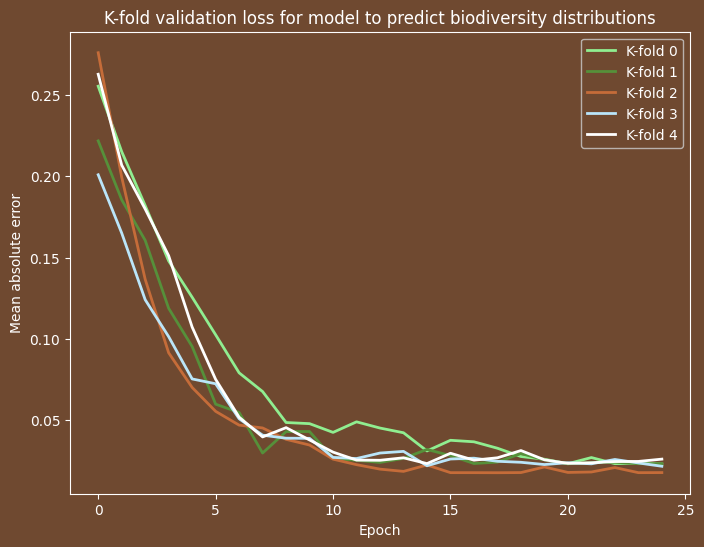

In [4]:
import matplotlib.pyplot as plt

# Only take first 25 epochs as the data hits it's minimum around 18 epochs.
y0 = data[0][:25]
y1 = data[1][:25]
y2 = data[2][:25]
y3 = data[3][:25]
y4 = data[4][:25]

# Plot k-fold validation losses.
x = range(25)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y0, label='K-fold 0', color='#90ee90', linewidth=2)
ax.plot(x, y1, label='K-fold 1', color='#56903a', linewidth=2)
ax.plot(x, y2, label='K-fold 2', color='#c56c39', linewidth=2)
ax.plot(x, y3, label='K-fold 3', color='#bae5f9', linewidth=2)
ax.plot(x, y4, label='K-fold 4', color='#ffffff', linewidth=2)
ax.set_title("K-fold validation loss for model to predict biodiversity distributions", color='white')
ax.set_xlabel("Epoch", color='white')
ax.set_ylabel("Mean absolute error", color='white')

# Customize graph for theme.
ax.set_facecolor('#6f4930')
fig.set_facecolor('#6f4930')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')

# Add legend.
leg = ax.legend()
leg.get_frame().set_facecolor('#6f4930')
for text in leg.get_texts():
    text.set_color('white')
plt.show()